In [14]:
import torch

# Explaining a single example

First, we need to load the dataset that we are interested in explaining. To be able to explain the decision of a model we only need the graphs itself (including the features), but because we also want to plot the explanations later, we also need the node labels to color them.

It's important to note here that the PGExplainer requires the graphs to be represented by edge index and not an adjacency matrix. 

In [15]:
from ExplanationEvaluation.datasets.dataset_loaders import load_dataset

graphs, features, labels, _, _, _ = load_dataset('syn1')
graphs = torch.tensor(graphs)
features = torch.tensor(features)
labels = torch.tensor(labels)

Loading syn1 dataset


Second, you will need to load the model that you wish to explain. For the model to work with the explainers there are a few restrictions. For an example, we recommend to look at the file: models/GNN_paper.py


#### PGExplainer
For the PGExplainer, the explainer uses the models embeddings to initialize the graph sampling procedure. For this reason, there are two minor restrictions:
1. The model needs a `model.embedding_size` parameter that returns the size of the embedding 
2. In the forward pass, when predicting an outcome for a given sample, the embedding has to be determined using a 'model.embedding(self, features, edge_index, edge_weights) call. 

#### GNNExplainer
For the GNNExplainer, the restrictions are a bit more serious. Specifically, it needs the model to be implemented using the PyTorch-Geometric library. This is because for the GNNExplainer the mask is directly inserted into the model instead of using the edge weights.


In [3]:
# Overwrite these models with your own if you want to
from ExplanationEvaluation.models.GNN_paper import NodeGCN
model = NodeGCN(10, 4)

path = "./ExplanationEvaluation/models/pretrained/GNN/syn1/best_model"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Now, before we do anything else we need to consider what task the original model is performing. For explaining a models decision there are a few subtle difference between node and graph classification. For this reason, we need to explicitely pass this to the explainer. 

It would normally be possible to derive this from the dataset (this is in fact what we are doing in the replication script), but to keep it simple we are just going to set it directly here. 

In [4]:
# task = 'graph'
task = 'node'

As this stage we can finally start to construct the explainer itself. While we are obviously going to use the PGExplainer here, it should make no difference which explainer is chosen for the past or upcomming steps. Both the PGExplainer and the GNNExplainer inherit from the same baseclass. 

The only small thing we need to be careful with is the initialization of the explainers. To findout exactly which parameters are available for this we suggest that you have a look at the code. For now it is enough to know that the explainer takes the model to be explainer, the graphs from the dataset, the node features and the classification task as its input. These first parameters are consistent among the explainers. 

In [5]:
from ExplanationEvaluation.explainers.PGExplainer import PGExplainer
explainer = PGExplainer(model, graphs, features, task)

With the explainer initialized there is one final step before we can start explaining some classification decisions. We need to call `explainer.prepare(indices)` to prepare the model for explaining. In the case of the PGExplainer this is the moment that we actually train the explainer. For the GNNExplainer this step is not really needed. 

The prepare method takes as list of indices as its input. These indices should correspond to the set of indices that we will wish to explain later. For node classification tasks this corresponds to indices of nodes while for graph classificationd datasets is corresponds to graphs. 

In [6]:
# We use the same indices as used in the original paper
indices = range(400, 700, 5)
explainer.prepare(indices)

100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Look at that, we have an explainer ready to go. All that is left now is to test it. 

In [7]:
idx = indices[0] # select a node to explain, this needs to be part of the list of indices
graph, expl = explainer.explain(idx)

Now visualize it

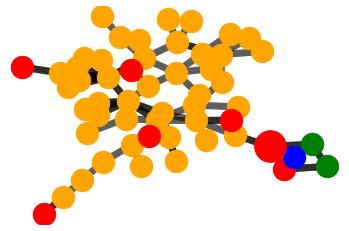

In [8]:
from ExplanationEvaluation.utils.plotting import plot
plot(graph, expl, labels, 400, 12, 100, 'syn1', show=True)

Perfect! We can clearly see the house motif of the dataset. 

# Evaluating the explainer
*Note that we are depending on the explainer initialized in the previous section for this part.*

To evaluate the performance of the explainer we need to first get some more information about the dataset. Specifically, we need to get the ground-truth label for all edges. In addition to this, to be able to fully replicate the results, we also need to make sure that we only evaluate over the nodes that have a sensible ground-truth definition. 

In [9]:
from ExplanationEvaluation.datasets.ground_truth_loaders import load_dataset_ground_truth
explanation_labels, indices = load_dataset_ground_truth('syn1')

With this information extracted, we can start loading the evaluation methods. Note that we dont have a specific method for the qualitative evaluation. For this part of the evaluation we will simply plot each graph later. 

In [10]:
from ExplanationEvaluation.evaluation.AUCEvaluation import AUCEvaluation
from ExplanationEvaluation.evaluation.EfficiencyEvaluation import EfficiencyEvluation

auc_evaluation = AUCEvaluation(task, explanation_labels, indices)
inference_eval = EfficiencyEvluation()

To keep the example clean, we will only run the evaluation ones. For the real replication experiment the function we are using below is called a total of 10 times. Because we want to make sure that the experiments do not interfer with eachother in consequtive runs, you will find that within the experiment function the explainer is retrained. 

In [11]:
from ExplanationEvaluation.tasks.replication import run_experiment

auc, time = run_experiment(inference_eval, auc_evaluation, explainer, indices)

100%|██████████| 60/60 [00:02<00:00, 23.77it/s]


Let's have a look at our results below. We can see that the auc is about the same as we present in the paper. The inference time is a little different. For our inital evaluation we worked with python scripts directly instead of jupyter notebooks. 

In [12]:
print(auc)
print(time)

0.9992157859078591
42.08665688832601


To close of our evaluation we only need to run the qualitative evaluation. In our real replication experiment these results are directly written to a file, but for now we will simply show the images here. 

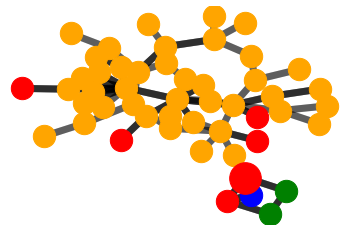

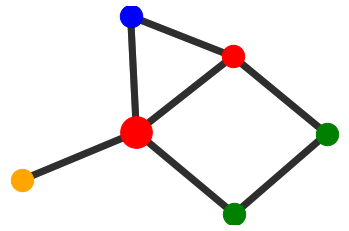

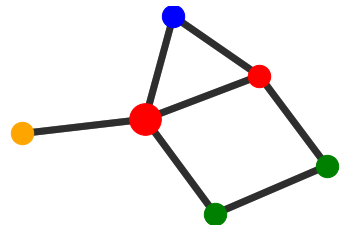

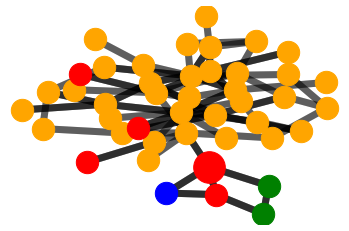

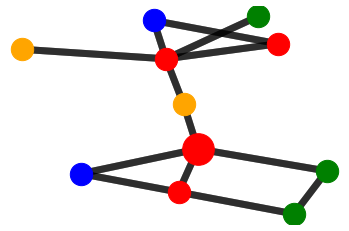

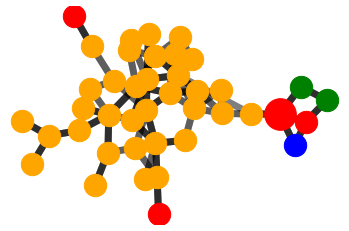

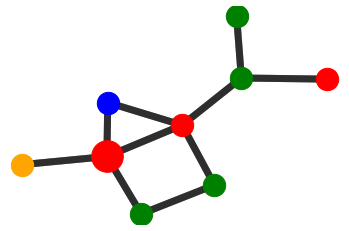

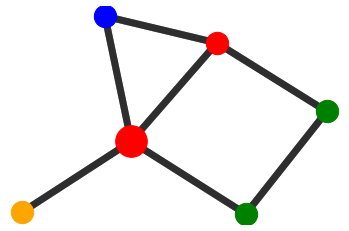

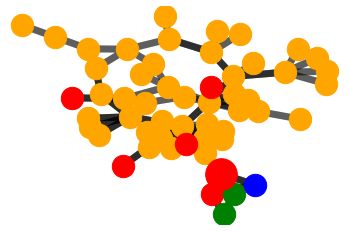

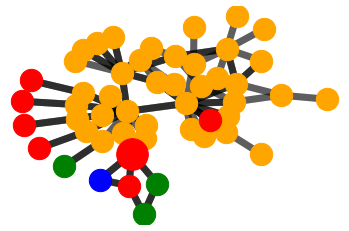

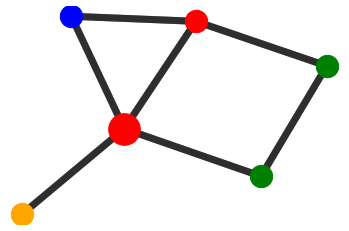

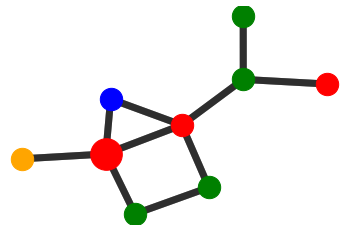

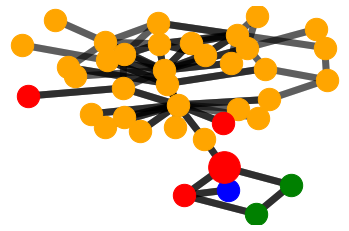

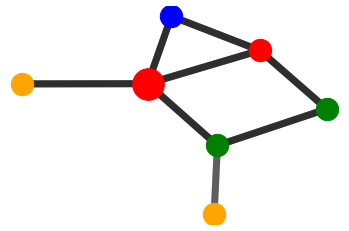

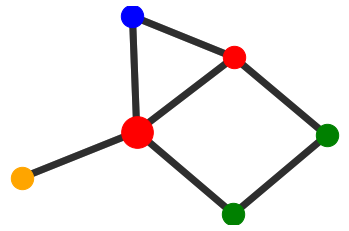

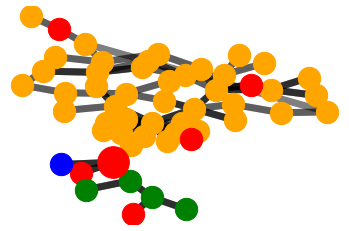

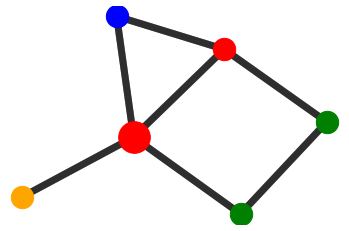

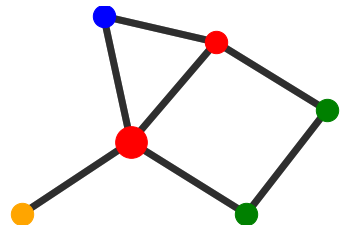

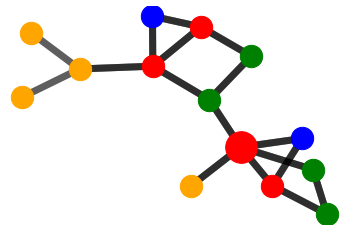

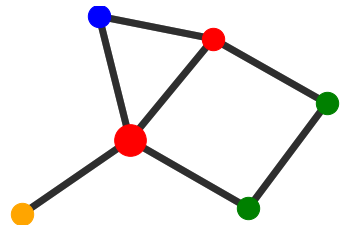

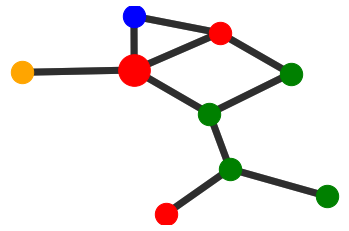

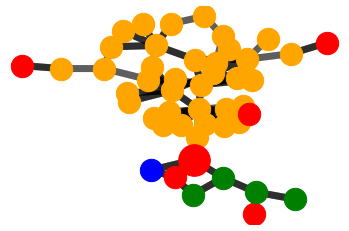

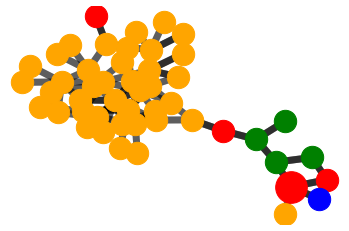

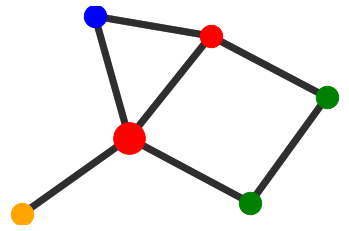

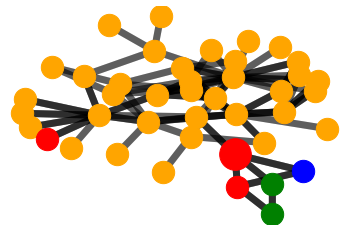

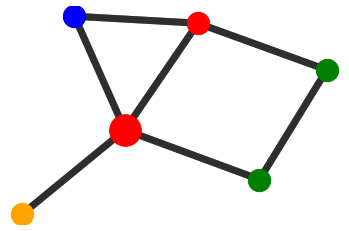

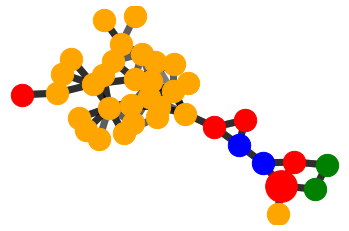

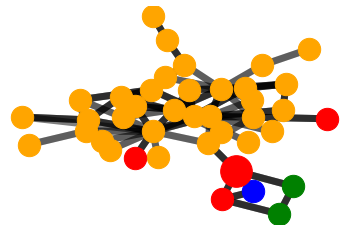

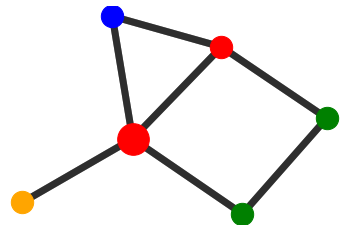

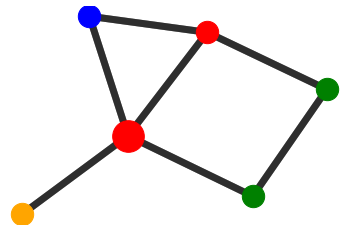

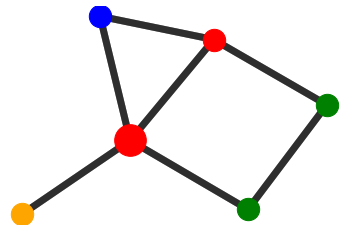

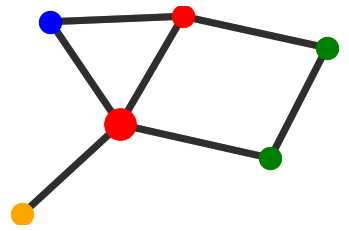

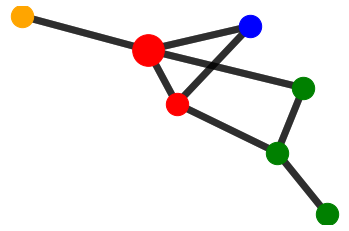

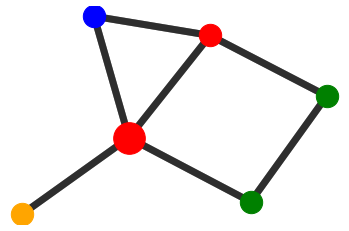

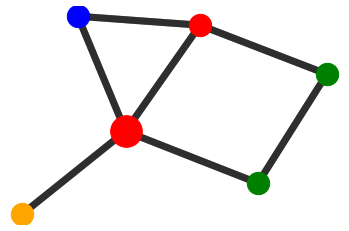

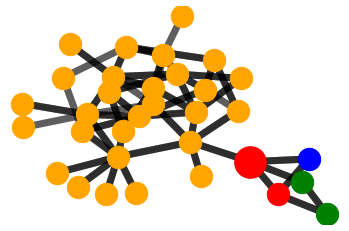

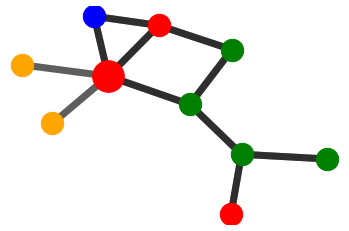

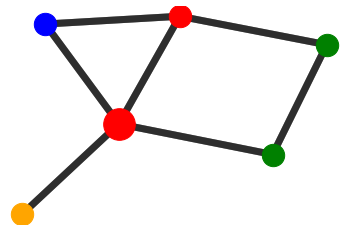

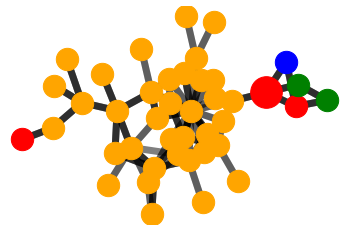

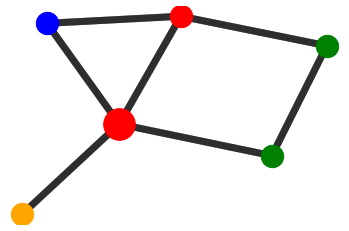

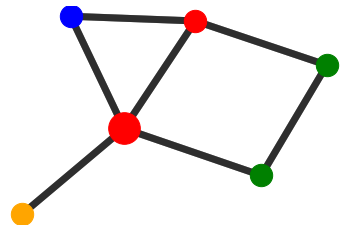

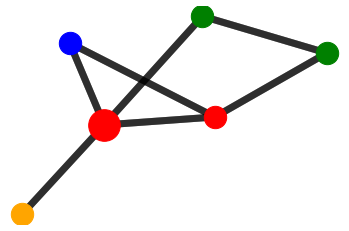

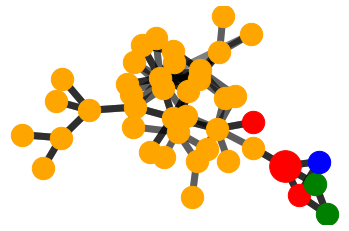

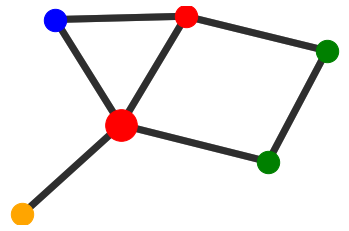

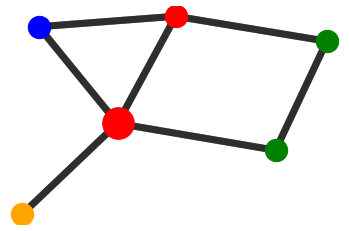

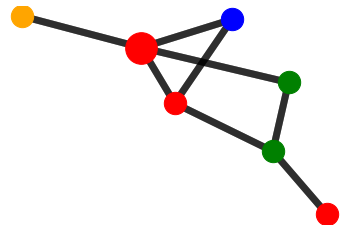

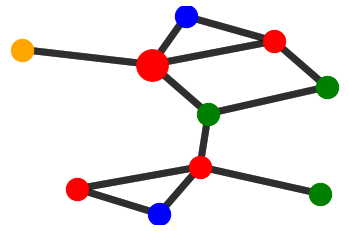

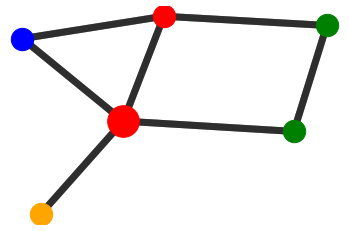

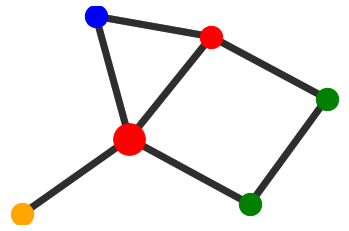

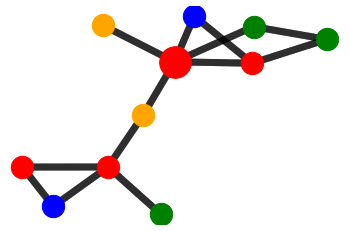

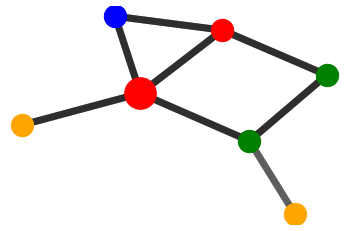

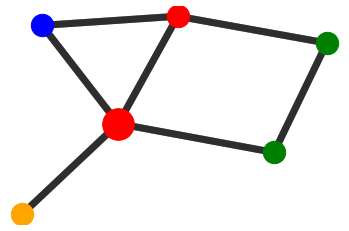

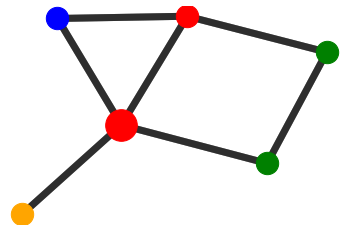

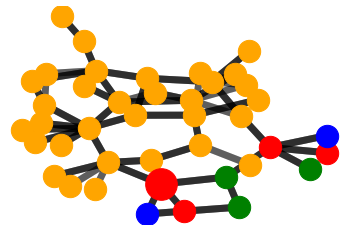

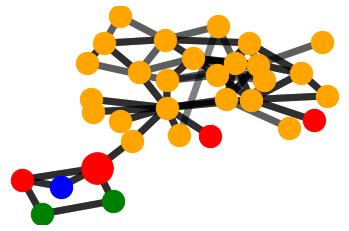

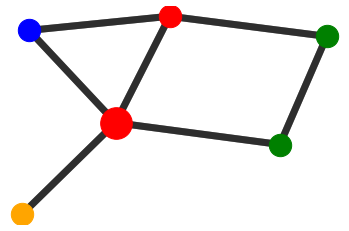

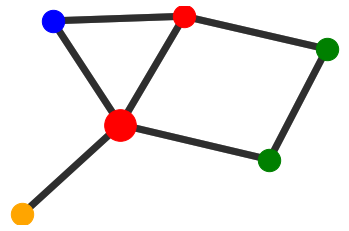

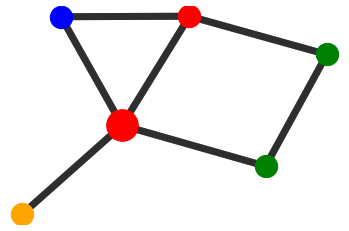

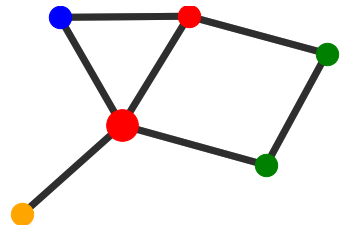

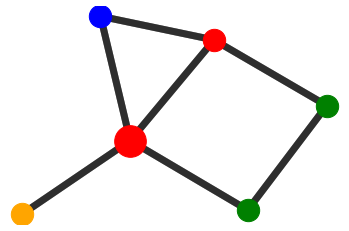

In [13]:
for idx in indices:
    graph, expl = explainer.explain(idx)
    plot(graph, expl, labels, idx, 12, 100, 'syn1', show=True)